# Question 2 -  Predicting the finding of a complaint investigation
#### Mihir Bhaskar
#### 11/23/2021

For presentation: higher officers or white officers could get away with more stuff. To say they got away disproporationately needs enough cases of people getting cauhgt that are non-white or lower ranked officers. Need



In [243]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pyprojroot import here

from statsmodels.stats.outliers_influence import variance_inflation_factor   
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import pydot
from yellowbrick.features import RadViz

import graphviz
from graphviz import Source
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from dtreeviz.trees import dtreeviz
from sklearn.linear_model import LogisticRegression 

## 1. Import, merge, and process data

In [146]:
# Importing complaint-level data
df = pd.read_csv(here('./data/CleanComplaints_FindingLevel.csv'))

df.head()

,CRID,OfficerID,Allegation,Finding,Outcome,Beat,IncidentDate,StartDate,EndDate,InvestigatorRank,...,physical_violence,injury,weapon,on_duty,officer_white,witness_white,officer_male,witness_male,officer_cmp_count,incident_year
0,1073326,18560,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
1,1073326,24186,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
2,1073326,18571,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015
3,1073326,32099,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,0,0,1,0,0,2015
4,1073326,14476,Unnecessary Display Of Weapon / Off Duty,No Affidavit,No Action Taken,621.0,2015-01-01,2015-01-12,2015-09-14,NaN,...,0,0,1,0,1,0,1,0,0,2015


In [147]:
# Merging on census tract-level features, stored in the 'Combined' dataset
tractlevel = pd.read_csv(here('./data/Combined.csv'))

df = df.merge(tractlevel, how='left', on=['geo_id'])

In [148]:
# Drop columns that are not used or have already been converted into dummy variables
df.drop(columns=['OfficerID', 'Allegation', 'Outcome', 'Beat', 'IncidentDate', 'StartDate', 'EndDate',
                'InvestigatorRank', 'officer_appt_date', 'officer_race', 'officer_gender',
                 'witness_race', 'witness_gender', 'geometry', 'GEOID10', 'geo_id'], inplace=True)

## 2. Variable selection and description

In [149]:
# Describing the category we are predicting (i.e. the different potential classes)
df[['Finding', 'CRID']].groupby('Finding').count()

,CRID
Finding,
Exonerated,70
No Affidavit,398
Not Sustained,162
Sustained,112
Unfounded,251
Unknown,187


In [144]:
# To-do if time: create graph of all the categorical variables I created at the complaint-level (complaint type, officer age, etc.)

In [150]:
# Checking for correlations between features 

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = df.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

corr_triu

Number of feature pairs that are highly correlated (i.e. >80%): 79


Correlation Coefficient
Col1                      Col2                                       
DECEPTIVE PRACTICE        THEFT                              0.986841
commercial_establishments DECEPTIVE PRACTICE                 0.968372
                          THEFT                              0.966038
DP05_0037PE               DP05_0038PE                       -0.947886
BATTERY                   OTHER OFFENSE                      0.946772
...                                                               ...
DP03_0066PE               DP05_0024PE                        0.805326
DP03_0098PE               DP05_0037PE                       -0.805021
commercial_establishments STALKING                           0.804893
DP03_0027PE               DP03_0031PE                       -0.801561
CRIM SEXUAL ASSAULT       ROBBERY                            0.800488

[79 rows x 1 columns]

In [154]:
# Identify the variables that contribute disproportionately to variance inflation factor (dealing with multicollinearity)

# The code below was sourced from this linke: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python

# This function calculates the variance inflation factor for each variable, and returns a list of those variables that fall
# under the threshold of 5 (i.e. do not contribute large amounts to variance inflation)
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return variables

# Based on the X feature set, get a list of variables that should be kept according to VIF

# Create a temporary X set that will be fed into the VIF functio
tmp = df.drop(columns=['CRID', 'Finding']) # Dropping the y column
tmp = tmp.select_dtypes(['number']) # Selecting only numeric values
tmp = tmp.dropna() # Dropping any NA values that will break the code


# Run the VIF function, to get back a list of variables we should keep according to VIF
vif_keep = calculate_vif_(tmp, thresh=5.0)

dropping 'incident_year' at index: 11
dropping 'DP02_0010PE' at index: 15
dropping 'DP03_0027PE' at index: 51
dropping 'DP02_0067PE' at index: 33
dropping 'DP02_0016E' at index: 17
dropping 'DP03_0004PE' at index: 43
dropping 'DP05_0003PE' at index: 78
dropping 'DP03_0064PE' at index: 55
dropping 'DP02_0080PE' at index: 36
dropping 'DP05_0038PE' at index: 80
dropping 'DP05_0018E' at index: 76
dropping 'BATTERY' at index: 91
dropping 'DP02_0032PE' at index: 20
dropping 'DP02_0153PE' at index: 40
dropping 'DP02_0015PE' at index: 16
dropping 'DP05_0019PE' at index: 73
dropping 'THEFT' at index: 116
dropping 'ASSAULT' at index: 86
dropping 'DP02_0026PE' at index: 17
dropping 'DP03_0098PE' at index: 55
dropping 'DP02_0072PE' at index: 29
dropping 'DP03_0013PE' at index: 38
dropping 'CRIMINAL DAMAGE' at index: 85
dropping 'DP02_0022PE' at index: 16
dropping 'B01001_001E' at index: 11
dropping 'OTHER OFFENSE' at index: 101
dropping 'DP04_0049E' at index: 55
dropping 'DECEPTIVE PRACTICE' at in

In [162]:
print(f'The total number of columns retained by the VIF seleciton process is {len(vif_keep)}')

vif_keep = tmp.columns[vif_keep]

The total number of columns retained by the VIF seleciton process is 50


## 3. Modelling sustained vs. not sustained

**Rationale**: The finding column as it currently is has too many classes, with too few observations per class (relative to the number of features we have) to predict all. This is why we first break down the problem to just look at those cases which were sustained against those that were not sustained. 

In [166]:
# Convert 'finding' into dummy variables
df_sust = pd.get_dummies(df, columns=['Finding'])

# Dropping columns that have any NA values (otherwise the modelling will not work)
df_sust.dropna(inplace=True)

# Keep only observations where finding was either sustained or not sustained
df_sust = df_sust[(df_sust['Finding_Sustained'] == 1) | (df_sust['Finding_Not Sustained'] == 1)]

# Dropping the other unused dummy variables created by 'finding'
df_sust.drop(columns=['Finding_Exonerated', 'Finding_No Affidavit', 'Finding_Not Sustained', 'Finding_Unfounded', 'Finding_Unknown'], inplace=True)

# Splitting the datasets up into X and Y
y = df_sust['Finding_Sustained']

X = df_sust.drop(columns=['CRID', 'Finding_Sustained'])
X = X.select_dtypes(['number']) 

# Creating a separate X set that removes the variables that contribute to VIF (i.e. keeping non collinear variables)
X_sub = X[vif_keep]

# Split into train and test, with a 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 11)         

X_sub_train, X_sub_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.20, random_state = 11)



In [167]:
# Show the distribution of labels
print(df_sust[['CRID', 'Finding_Sustained']].groupby('Finding_Sustained').count())

# Define labels to use on following graphs and confusion matrices
target_names = ['Not Sustained', 'Sustained']

                   CRID
Finding_Sustained      
0                   158
1                   109


### 3.1.a Naive Bayes Classification - using all features

              precision    recall  f1-score   support

           0      0.765     0.448     0.565        29
           1      0.568     0.840     0.677        25

    accuracy                          0.630        54
   macro avg      0.666     0.644     0.621        54
weighted avg      0.673     0.630     0.617        54



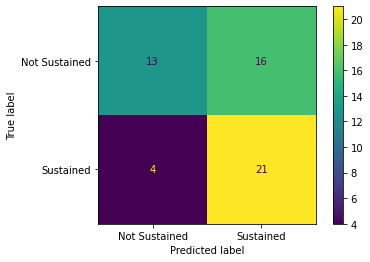

In [179]:
# Define model object
nb_full = GaussianNB()

# Fit to the training data and get predicitons
nb_full_pred = nb_full.fit(X_train,y_train).predict(X_test) 

# Print classification report
print(classification_report(y_test,nb_full_pred,digits = 3))

# Print confusion matrix
cm = confusion_matrix(y_test,nb_full_pred) 
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()


### 3.1.b Naive Bayes Classification - using subset of low VIF features

              precision    recall  f1-score   support

           0      0.688     0.759     0.721        29
           1      0.682     0.600     0.638        25

    accuracy                          0.685        54
   macro avg      0.685     0.679     0.680        54
weighted avg      0.685     0.685     0.683        54



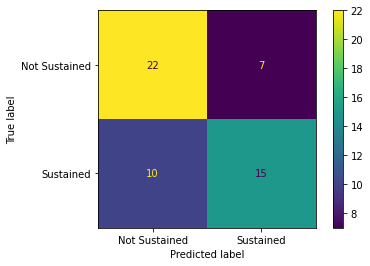

In [180]:
# Defining model
nb_sub = GaussianNB()

# Fitting using X_sub_train instead of X_train, and fitting using X_sub_test
nb_sub_pred = nb_sub.fit(X_sub_train,y_train).predict(X_sub_test) 

# Printing classification report and confusion matrix
print(classification_report(y_test,nb_sub_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test, nb_sub_pred) 
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

### 3.2.a Tuned KNN - using all features 

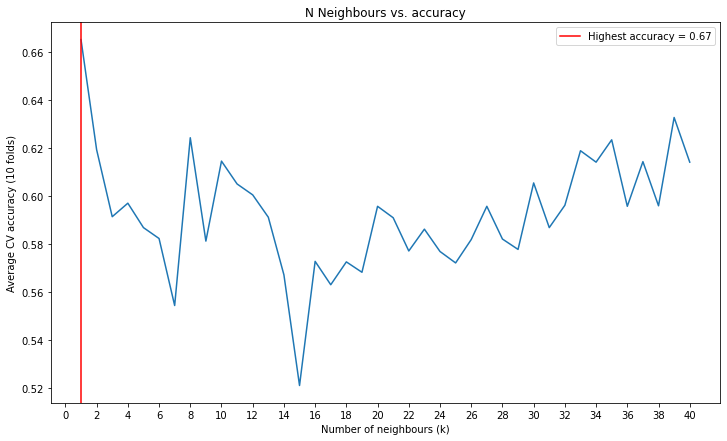

In [170]:
# Tuning KNN - finding the optimal number of neighbours based on accuracy score

avg_cv_accuracy = [] # Initialising list in which to store CV accuracy values for each 'k'

# Looping over range of possible values for k (number of neighbours)
for k in range(1,41):
    
    # Defining the model and fitting it to the data
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train, y_train)
    
    # Getting the CV accuracy scores, and averaging for each iteration, and appending to the list defined earlier
    scores = cross_val_score(knn_model, X_train, y_train, scoring = 'accuracy', cv=10, n_jobs=-1)
    avg_cv_accuracy.append(np.mean(scores))
    
# Getting the optimal number of neighbours as the 'k' where avg. CV recall is maximised:
highest_accuracy_index = avg_cv_accuracy.index(max(avg_cv_accuracy)) + 1     
    
# Plotting the 'k' values against CV accuracy
plt.figure(figsize = (12,7))
plt.plot(range(1, 41), avg_cv_accuracy)
plt.xticks(range(0,41, 2))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Average CV accuracy (10 folds)')
plt.title('N Neighbours vs. accuracy')
plt.axis('tight')
plt.axvline(x = highest_accuracy_index, color = 'red', label = 'Highest accuracy = {:.2f}'.format(max(avg_cv_accuracy)))
plt.legend()



              precision    recall  f1-score   support

           0      0.697     0.793     0.742        29
           1      0.714     0.600     0.652        25

    accuracy                          0.704        54
   macro avg      0.706     0.697     0.697        54
weighted avg      0.705     0.704     0.700        54



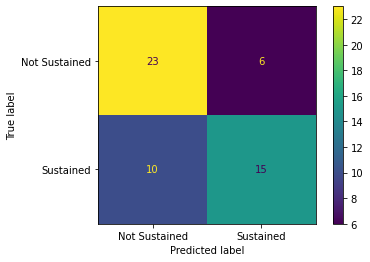

In [181]:
# Fitting the KNN model with k = 1, as selected above
knn_full = KNeighborsClassifier(n_neighbors = 1)
knn_full.fit(X_train, y_train)
knn_full_pred = knn_full.predict(X_test)

# Printing classification report 
print(classification_report(y_test, knn_full_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, knn_full_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()


### 3.2.b Tuned KNN - using subset of low VIF features 

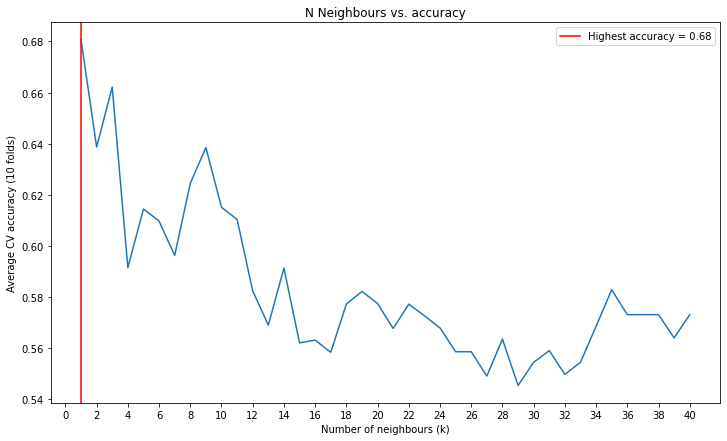

In [172]:
# Tuning KNN - finding the optimal number of neighbours based on accuracy score

avg_cv_accuracy = [] # Initialising list in which to store CV accuracy values for each 'k'

# Looping over range of possible values for k (number of neighbours)
for k in range(1,41):
    
    # Defining the model and fitting it to the data
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_sub_train, y_train)
    
    # Getting the CV accuracy scores, and averaging for each iteration, and appending to the list defined earlier
    scores = cross_val_score(knn_model, X_sub_train, y_train, scoring = 'accuracy', cv=10, n_jobs=-1)
    avg_cv_accuracy.append(np.mean(scores))
    
# Getting the optimal number of neighbours as the 'k' where avg. CV recall is maximised:
highest_accuracy_index = avg_cv_accuracy.index(max(avg_cv_accuracy)) + 1     
    
# Plotting the 'k' values against CV accuracy
plt.figure(figsize = (12,7))
plt.plot(range(1, 41), avg_cv_accuracy)
plt.xticks(range(0,41, 2))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Average CV accuracy (10 folds)')
plt.title('N Neighbours vs. accuracy')
plt.axis('tight')
plt.axvline(x = highest_accuracy_index, color = 'red', label = 'Highest accuracy = {:.2f}'.format(max(avg_cv_accuracy)))
plt.legend()

              precision    recall  f1-score   support

           0      0.750     0.724     0.737        29
           1      0.692     0.720     0.706        25

    accuracy                          0.722        54
   macro avg      0.721     0.722     0.721        54
weighted avg      0.723     0.722     0.723        54



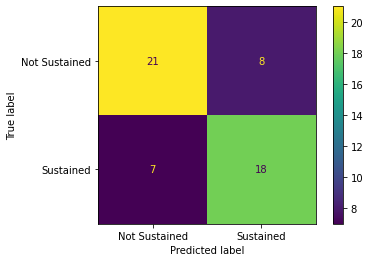

In [182]:
# Fitting the KNN model with k = 1, as selected above
knn_sub = KNeighborsClassifier(n_neighbors = 1)
knn_sub.fit(X_sub_train, y_train)
knn_sub_pred = knn_sub.predict(X_sub_test)

# Printing classification report 
print(classification_report(y_test, knn_sub_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, knn_sub_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()

### 3.3.a. - Decision Tree, using all features

              precision    recall  f1-score   support

           0      0.675     0.931     0.783        29
           1      0.857     0.480     0.615        25

    accuracy                          0.722        54
   macro avg      0.766     0.706     0.699        54
weighted avg      0.759     0.722     0.705        54



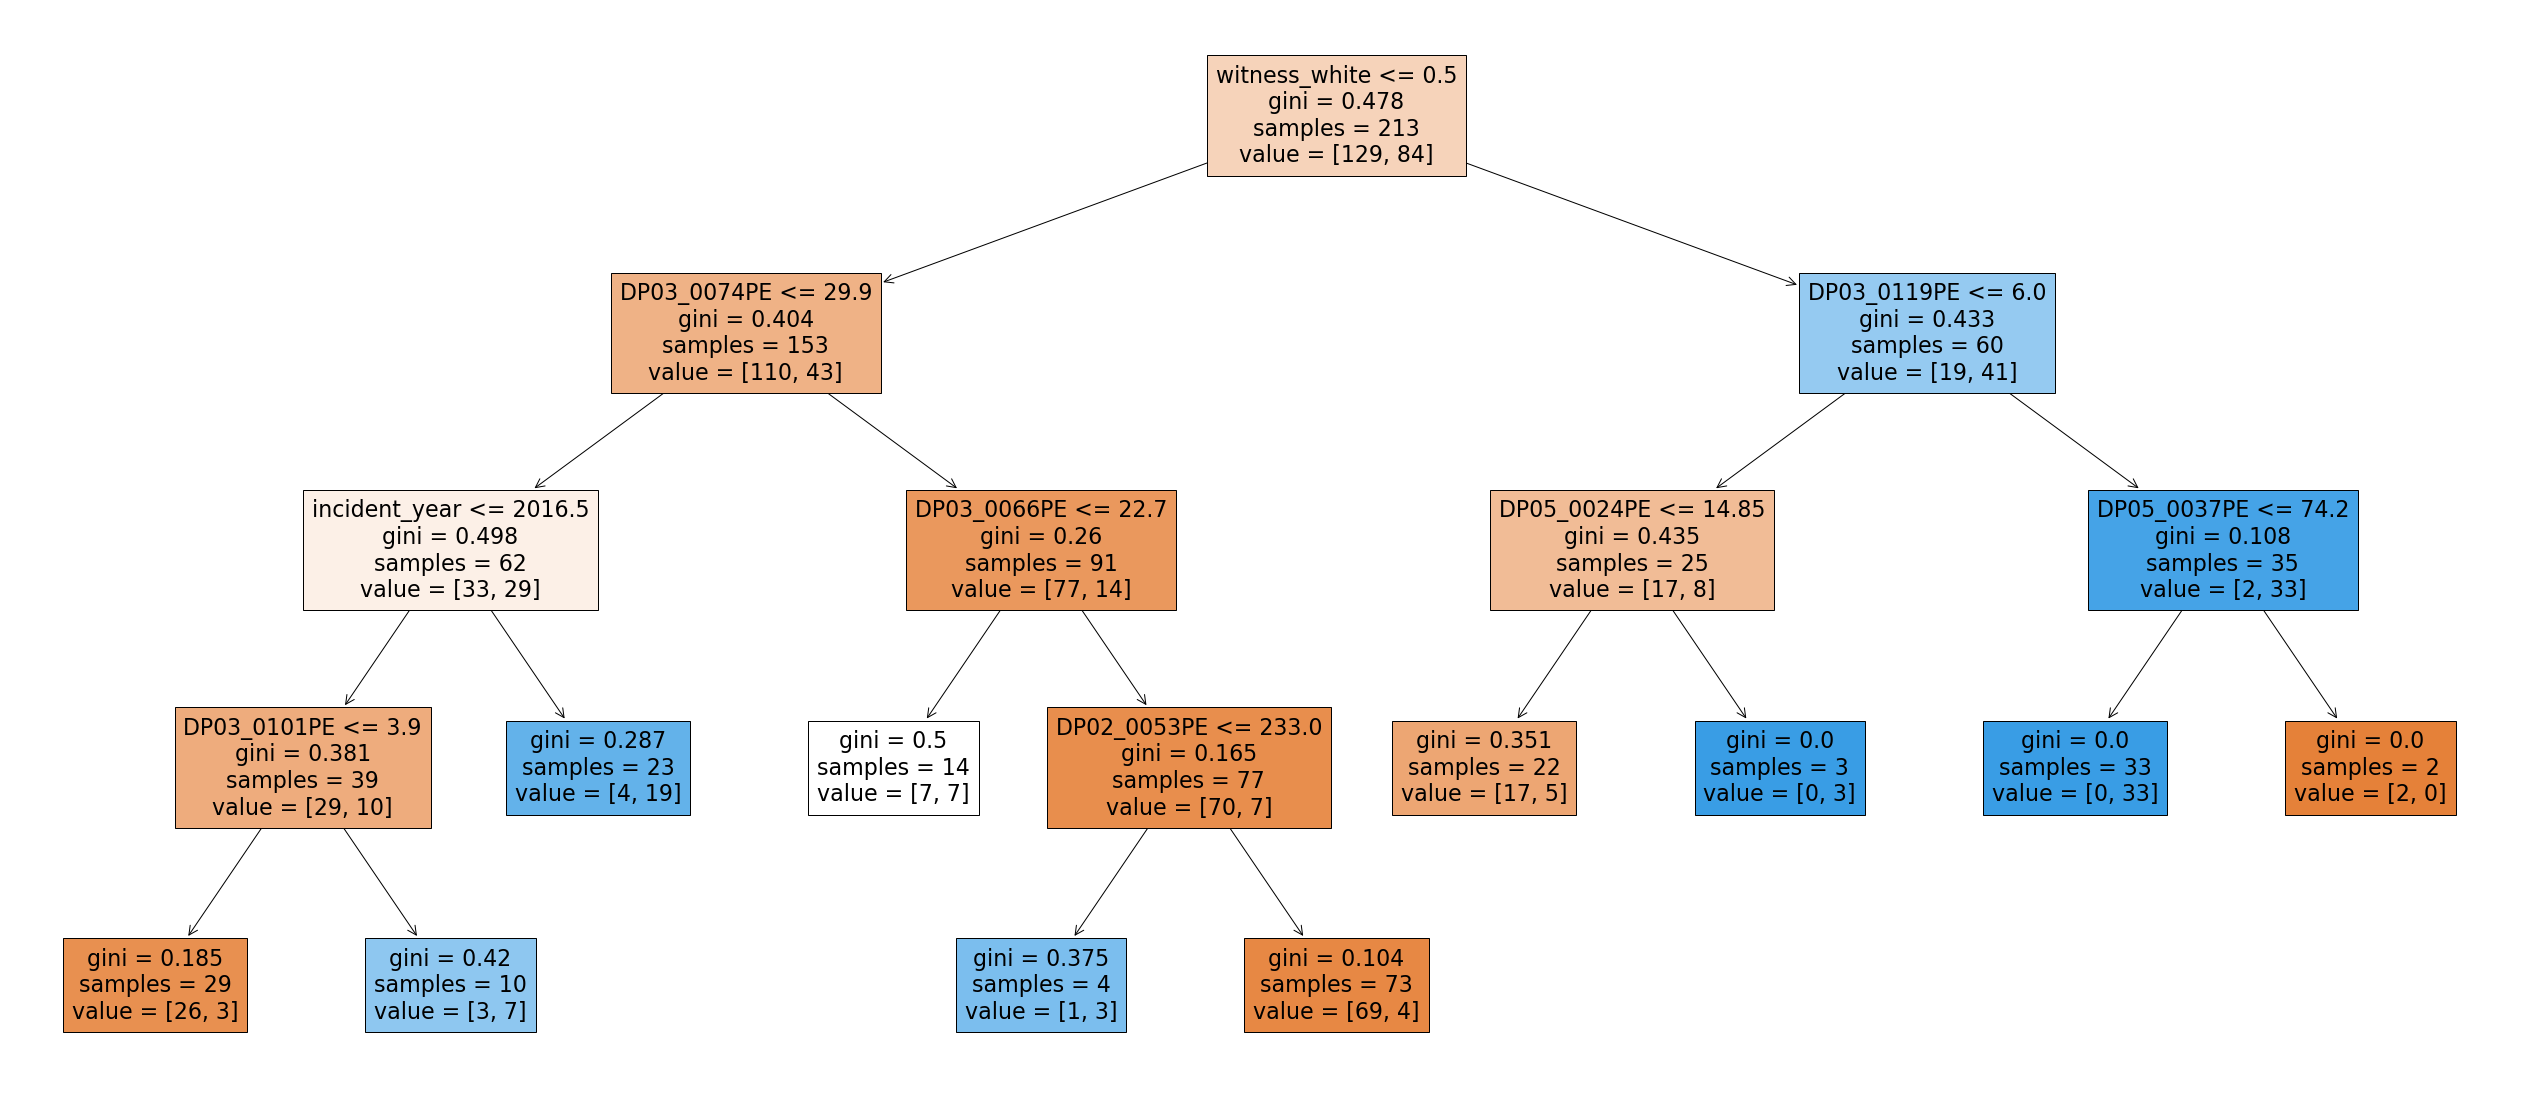

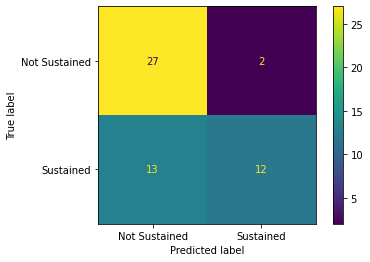

In [184]:
# Decision tree classifier
dt_full = DecisionTreeClassifier(random_state=1, max_leaf_nodes=10)
dt_full.fit(X_train, y_train)

# Plotting the tree
fig = plt.figure(figsize=(45,20))
plot_tree = tree.plot_tree(dt_full, 
                   feature_names=X_train.columns,  
                   filled=True)


dt_full_pred = dt_full.predict(X_test)

print(classification_report(y_test, dt_full_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, dt_full_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()


### 3.3.b - Decision Tree, using subset of low VIF features

              precision    recall  f1-score   support

           0      0.675     0.931     0.783        29
           1      0.857     0.480     0.615        25

    accuracy                          0.722        54
   macro avg      0.766     0.706     0.699        54
weighted avg      0.759     0.722     0.705        54



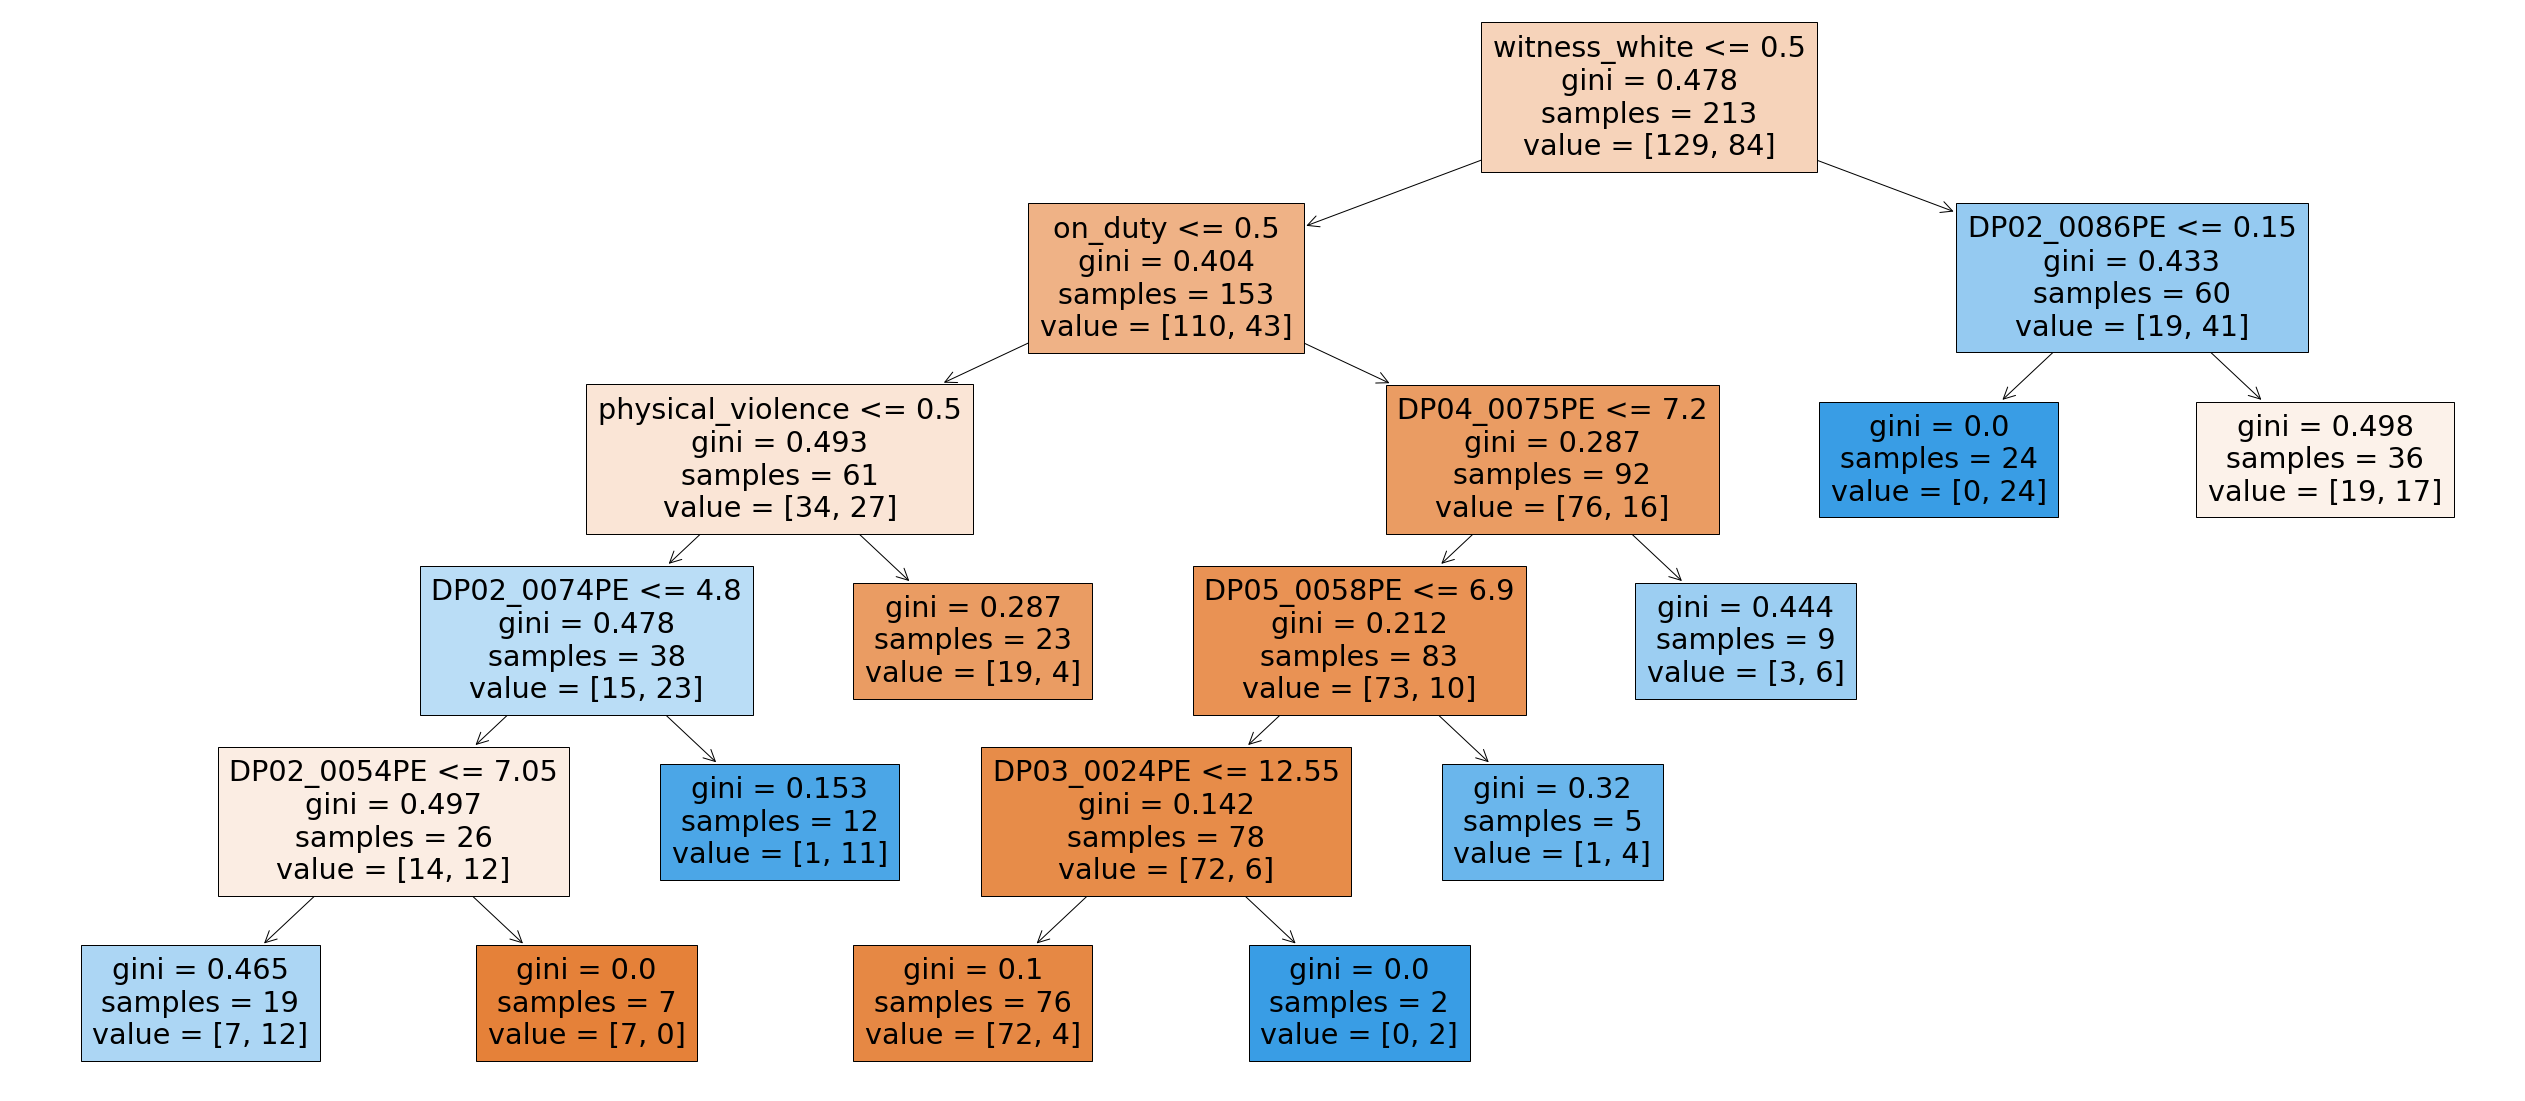

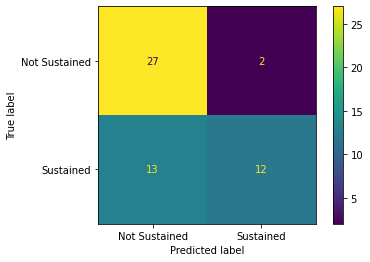

In [185]:
# Decision tree classifier
dt_sub = DecisionTreeClassifier(random_state=1, max_leaf_nodes=10)
dt_sub.fit(X_sub_train, y_train)

# Plotting the tree
fig = plt.figure(figsize=(45,20))
plot_tree = tree.plot_tree(dt_sub, 
                   feature_names=X_sub_train.columns,  
                   filled=True)


dt_sub_pred = dt_sub.predict(X_sub_test)

print(classification_report(y_test, dt_sub_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, dt_sub_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()

### 3.4.a - Random Forest, using all features 

              precision    recall  f1-score   support

           0      0.714     0.862     0.781        29
           1      0.789     0.600     0.682        25

    accuracy                          0.741        54
   macro avg      0.752     0.731     0.732        54
weighted avg      0.749     0.741     0.735        54



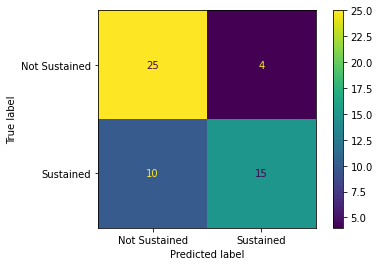

In [188]:
# Random forest classifier
rf_full = RandomForestClassifier(max_depth=10, random_state=1)
rf_full.fit(X_train, y_train)
rf_full_pred = rf_full.predict(X_test)


print(classification_report(y_test, rf_full_pred, digits = 3))

cm = confusion_matrix(y_test,rf_full_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

### 3.4.b - Random forest, using subset of low VIF features

              precision    recall  f1-score   support

           0      0.806     0.862     0.833        29
           1      0.826     0.760     0.792        25

    accuracy                          0.815        54
   macro avg      0.816     0.811     0.812        54
weighted avg      0.816     0.815     0.814        54



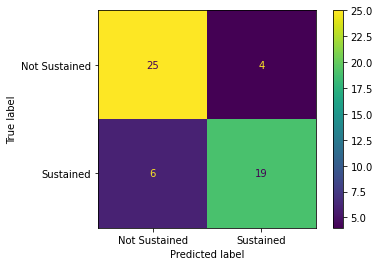

In [201]:
# Random forest classifier
rf_sub = RandomForestClassifier(max_depth=10, random_state=1)
rf_sub.fit(X_sub_train, y_train)
rf_sub_pred = rf_sub.predict(X_sub_test)


print(classification_report(y_test, rf_sub_pred, digits = 3))

cm = confusion_matrix(y_test,rf_sub_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

### 3.5 - Choosing the best model

In [190]:
# In classification settings, the best way to choose the model is to run an AUC/ROC

'''Trial code to make this into a loop 
d = {}
for x in range(1, 10):
    d["string{0}".format(x)] = "Hello"
    
probs = {}
auc = {}
fpr = {}
tpr = {}

for var in ['nb', 'knn', 'dt', 'rf']:
    for type in ['full', 'sub']:
        
        # Get predicted probabilities
        probs['{:s}_{:s}'.format(var, type)] = 
        
'''

# Getting the predicted probabilities, AUC, and FPR/TPR/Thresholds for all the models run

# NB - Full
nb_full_probs = nb_full.predict_proba(X_test)

auc_nb_full = roc_auc_score(y_test, nb_full_probs[:, 1])

nb_full_fpr, nb_full_tpr, thresholds = roc_curve(y_test, nb_full_probs[:, 1])

# NB - Sub
nb_sub_probs = nb_sub.predict_proba(X_sub_test)

auc_nb_sub = roc_auc_score(y_test, nb_sub_probs[:, 1])

nb_sub_fpr, nb_sub_tpr, thresholds = roc_curve(y_test, nb_sub_probs[:, 1])

# KNN full
knn_full_probs = knn_full.predict_proba(X_test)

auc_knn_full = roc_auc_score(y_test, knn_full_probs[:, 1])

knn_full_fpr, knn_full_tpr, thresholds = roc_curve(y_test, knn_full_probs[:, 1])

# KNN sub
knn_sub_probs = knn_sub.predict_proba(X_sub_test)

auc_knn_sub = roc_auc_score(y_test, knn_sub_probs[:, 1])

knn_sub_fpr, knn_sub_tpr, thresholds = roc_curve(y_test, knn_sub_probs[:, 1])

# DT full
dt_full_probs = dt_full.predict_proba(X_test)

auc_dt_full = roc_auc_score(y_test, dt_full_probs[:, 1])

dt_full_fpr, dt_full_tpr, thresholds = roc_curve(y_test, dt_full_probs[:, 1])

# DT sub
dt_sub_probs = dt_sub.predict_proba(X_sub_test)

auc_dt_sub = roc_auc_score(y_test, dt_sub_probs[:, 1])

dt_sub_fpr, dt_sub_tpr, thresholds = roc_curve(y_test, dt_sub_probs[:, 1])

# RF full
rf_full_probs = rf_full.predict_proba(X_test)

auc_rf_full = roc_auc_score(y_test, rf_full_probs[:, 1])

rf_full_fpr, rf_full_tpr, thresholds = roc_curve(y_test, rf_full_probs[:, 1])

# RF sub
rf_sub_probs = rf_sub.predict_proba(X_sub_test)

auc_rf_sub = roc_auc_score(y_test, rf_sub_probs[:, 1])

rf_sub_fpr, rf_sub_tpr, thresholds = roc_curve(y_test, rf_sub_probs[:, 1])

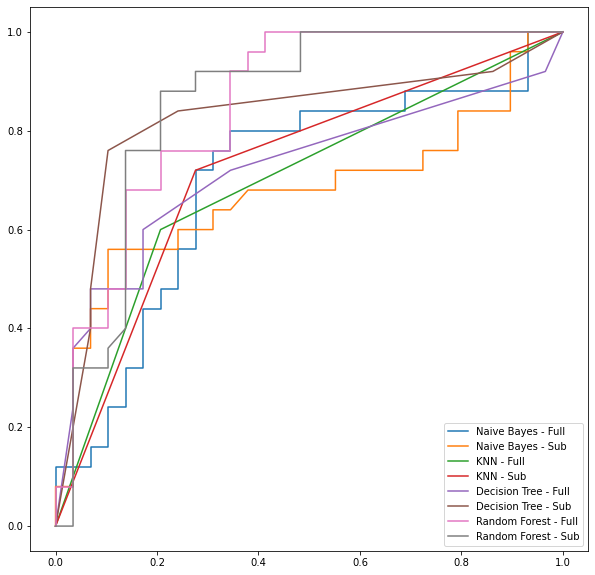

In [191]:
# Plot showing all models
plt.figure(figsize=(10,10))
plt.plot(nb_full_fpr, nb_full_tpr, label="Naive Bayes - Full")
plt.plot(nb_sub_fpr, nb_sub_tpr, label="Naive Bayes - Sub")

plt.plot(knn_full_fpr, knn_full_tpr, label="KNN - Full")
plt.plot(knn_sub_fpr, knn_sub_tpr, label="KNN - Sub")

plt.plot(dt_full_fpr, dt_full_tpr, label="Decision Tree - Full")
plt.plot(dt_sub_fpr, dt_sub_tpr, label="Decision Tree - Sub")

plt.plot(rf_full_fpr, rf_full_tpr, label="Random Forest - Full")
plt.plot(rf_sub_fpr, rf_sub_tpr, label="Random Forest - Sub")

plt.legend()
plt.show()

In [192]:
print(f'''
AUC for different models: \n
Naive Bayes Full: {auc_nb_full}\n
Naive Bayes Sub: {auc_nb_sub}\n
KNN Full: {auc_knn_full}\n
KNN Sub: {auc_knn_sub}\n
Decision Tree Full: {auc_dt_full}\n
Decision Tree Sub: {auc_dt_sub}\n
Random Forest Full: {auc_rf_full}\n
Random Forest Sub: {auc_rf_sub}\n
''')


AUC for different models: 

Naive Bayes Full: 0.7006896551724138

Naive Bayes Sub: 0.676551724137931

KNN Full: 0.6965517241379311

KNN Sub: 0.7220689655172413

Decision Tree Full: 0.7227586206896552

Decision Tree Sub: 0.8241379310344827

Random Forest Full: 0.8496551724137931

Random Forest Sub: 0.8558620689655172




### 3.6 - Tuning the best model - Random Forest with a subset of predictors

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 75}
              precision    recall  f1-score   support

           0      0.781     0.862     0.820        29
           1      0.818     0.720     0.766        25

    accuracy                          0.796        54
   macro avg      0.800     0.791     0.793        54
weighted avg      0.798     0.796     0.795        54



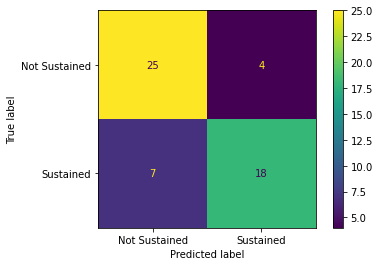

In [224]:
# Parameters to tune - values to test
param_grid = {'n_estimators': [5, 10, 25, 50, 75, 100, 125, 150],
              'min_samples_split': [1, 2, 5, 10, 20],
              'max_depth': [None, 5, 10, 20, 50]}

# Running the grid search
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', refit=True, n_jobs=-1)
grid.fit(X_sub_train, y_train)

# Printing the best parameters after tuning
print(grid.best_params_)

# Getting predicted probabilities from the best mode
rf_tuned_sub_pred = grid.predict(X_sub_test)

# Printing the classification report and confusion matrix
print(classification_report(y_test, rf_tuned_sub_pred, digits = 3))

cm = confusion_matrix(y_test,rf_tuned_sub_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

### 3.7 - Assessing our best model

    Feature Names  Importance
3         on_duty    0.071187
5   witness_white    0.064096
18    DP03_0030PE    0.048576
19    DP03_0045PE    0.040426
11    DP02_0055PE    0.037588
29    DP04_0075PE    0.037557
35       GAMBLING    0.033868
17    DP03_0024PE    0.033148
16    DP03_0022PE    0.030673
22    DP04_0064PE    0.030583


<AxesSubplot:xlabel='Importance', ylabel='Feature Names'>

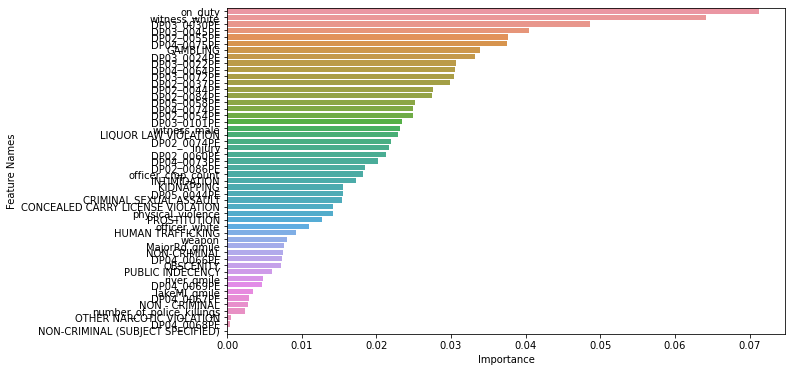

In [229]:
# Fitting RF model to get the feature importance method

rf_tuned_sub = RandomForestClassifier(n_estimators = grid.best_params_['n_estimators'], 
                                      min_samples_split = grid.best_params_['min_samples_split'],
                                      max_depth = grid.best_params_['max_depth']
                                     )

rf_tuned_sub.fit(X_sub_train, y_train)

feature_importance = rf_tuned_sub.feature_importances_

feature_df = pd.DataFrame({'Feature Names': X_sub_train.columns, 'Importance': feature_importance})

feature_df.sort_values('Importance', ascending=False, inplace=True)

print(feature_df.head(10))

# Plot 1 - looking at whole distribution of feature importances
plt.figure(figsize=(10,6))
sns.barplot(x = 'Feature Names', y = 'Importance', data = feature_df)

Text(0.5, 1.0, 'Feature Importance - Top 5, Tuned Random Forest')

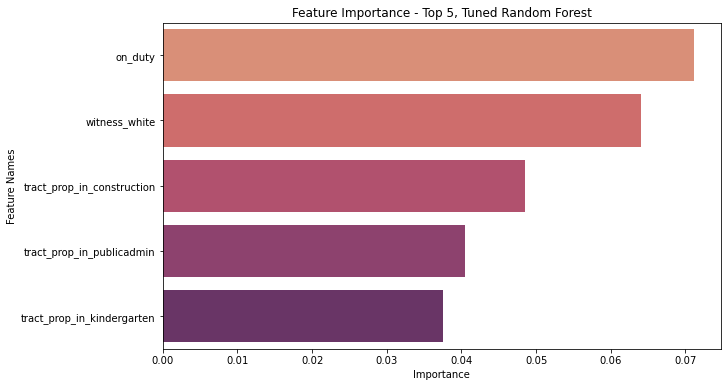

In [241]:
# Plot 2 - Zooming in on top 5 features, labelling nicely
plt.figure(figsize=(10,6))

# Replacing with actual variable names
feature_df.loc[feature_df['Feature Names'] == 'DP03_0030PE', 'Feature Names'] = 'tract_prop_in_construction'
feature_df.loc[feature_df['Feature Names'] == 'DP03_0045PE', 'Feature Names'] = 'tract_prop_in_publicadmin'
feature_df.loc[feature_df['Feature Names'] == 'DP02_0055PE', 'Feature Names'] = 'tract_prop_in_kindergarten'


sns.barplot(x = 'Importance', y = 'Feature Names', palette="flare", data = feature_df.iloc[:5])
plt.title('Feature Importance - Top 5, Tuned Random Forest')

In [263]:
# Categorical important features, showing a confusion matrix of sorts
print(df_sust.groupby('on_duty').agg({'Finding_Sustained':['count', 'mean']}))

print('\n')

print(df_sust.groupby('witness_white').agg({'Finding_Sustained':['count', 'mean']}))

        Finding_Sustained          
                    count      mean
on_duty                            
0                     134  0.597015
1                     133  0.218045


              Finding_Sustained          
                          count      mean
witness_white                            
0                           194  0.293814
1                            73  0.712329


### Predicting affidavit vs no affidavit (i.e. affidavit vs the rest)

In [ ]:
# Drop the useless dummies
df_affidavit = pd.get_dummies(df, columns=['Finding'])

df_affidavit.drop(columns=['Finding_Exonerated', 'Finding_Sustained', 'Finding_Not Sustained', 'Finding_Unfounded', 'Finding_Unknown'], inplace=True)

df_affidavit.dropna(inplace=True)

print(df_affidavit[['CRID', 'Finding_No Affidavit']].groupby('Finding_No Affidavit').count())

y = df_affidavit['Finding_No Affidavit']

#X = df_affidavit.drop(columns=['CRID', 'Finding_No Affidavit'])

#X = X.select_dtypes(['number']) 

#X = calculate_vif_(X, thresh=5.0)


# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 11)                                                      


In [ ]:
# Naive bayes

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['Affidavit','No Affidavit']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

In [ ]:
# KNN

# Step 1: choosing the optimal number of neighbours for classification based on accuracy score

avg_cv_accuracy = [] # Initialising list in which to store CV accuracy values for each 'k'

# Looping over range of possible values for k (number of neighbours)
for k in range(1,41):
    
    # Defining the model and fitting it to the data
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train, y_train)
    
    # Getting the CV accuracy scores, and averaging for each iteration, and appending to the list defined earlier
    scores = cross_val_score(knn_model, X_train, y_train, scoring = 'accuracy', cv=10, n_jobs=-1)
    avg_cv_accuracy.append(np.mean(scores))
    
# Getting the optimal number of neighbours as the 'k' where avg. CV recall is maximised:
highest_accuracy_index = avg_cv_accuracy.index(max(avg_cv_accuracy)) + 1     
    
# Plotting the 'k' values against CV accuracy
plt.figure(figsize = (12,7))
plt.plot(range(1, 41), avg_cv_accuracy)
plt.xticks(range(0,41, 2))
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Average CV accuracy (10 folds)')
plt.title('N Neighbours vs. accuracy')
plt.axis('tight')
plt.axvline(x = highest_accuracy_index, color = 'red', label = 'Highest accuracy = {:.2f}'.format(max(avg_cv_accuracy)))
plt.legend()

In [ ]:
# Fitting the KNN model and displaying results
# Step 2: fitting the model with k = 2

knn_model = KNeighborsClassifier(n_neighbors = 2)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

# Printing classification report 
print(classification_report(y_test, y_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, y_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=['Affidavit', 'No Affidavit'])
display_cm_bc.plot()

In [ ]:
# Decision tree classifier
dt = DecisionTreeClassifier(random_state=1, max_leaf_nodes=10)
dt.fit(X_train, y_train)

# Plotting the tree
fig = plt.figure(figsize=(45,20))
plot_tree = tree.plot_tree(dt, 
                   feature_names=X_train.columns,  
                   filled=True)


y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred, digits = 3))

In [ ]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


print(classification_report(y_test, y_pred, digits = 3))

cm = confusion_matrix(y_test,y_pred) 
target_names = ['Affidavit','No Affidavit']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()

In [ ]:
# Feature importance

# Fitting RF model to get the feature importance method

feature_importance = rf.feature_importances_

feature_df = pd.DataFrame({'Feature Names': X_train.columns, 'Importance': feature_importance})

feature_df.sort_values('Importance', ascending=False, inplace=True)

feature_df = feature_df[1:10]

print(feature_df)

plt.figure(figsize=(10,6))
sns.barplot(x = 'Feature Names', y = 'Importance', data = feature_df)

## Appendix - kitchen sink model with all classes

In [129]:
# Converting to numeric variable and assigning labels separately
df_all = df.copy()
df_all['Finding'] = df_all['Finding'].astype('category').cat.codes

# Dropping NAs for models to run
df_all.dropna(inplace=True)

y = df_all['Finding']

#X = df_all.drop(columns=['CRID', 'Finding'])

#X = X.select_dtypes(['number'])

#X = calculate_vif_(X, thresh=5.0)


# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 11)                                                      




              precision    recall  f1-score   support

           0      0.045     0.062     0.053        16
           1      0.457     0.468     0.462        79
           2      0.600     0.194     0.293        31
           3      0.094     0.250     0.136        12
           4      0.467     0.132     0.206        53
           5      0.197     0.400     0.264        30

    accuracy                          0.299       221
   macro avg      0.310     0.251     0.236       221
weighted avg      0.394     0.299     0.303       221



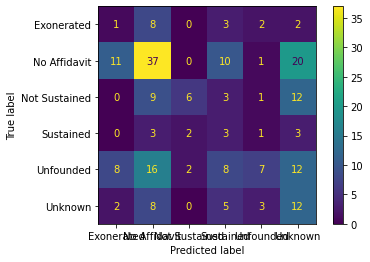

In [130]:
# Naive Bayes

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['Exonerated', 'No Affidavit', 'Not Sustained', 'Sustained', 'Unfounded', 'Unknown']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()


              precision    recall  f1-score   support

           0      0.667     0.375     0.480        16
           1      0.712     0.658     0.684        79
           2      0.424     0.452     0.438        31
           3      0.000     0.000     0.000        12
           4      0.481     0.491     0.486        53
           5      0.512     0.700     0.592        30

    accuracy                          0.538       221
   macro avg      0.466     0.446     0.447       221
weighted avg      0.547     0.538     0.538       221



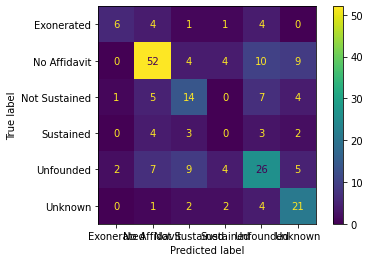

In [131]:
# Fitting the KNN model and displaying results
# Step 2: fitting the model with k = 3

knn_model = KNeighborsClassifier(n_neighbors = 1)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

# Printing classification report 
print(classification_report(y_test, y_pred, digits = 3))

# Displaying confusion matrix
cm_bc = confusion_matrix(y_test, y_pred)
display_cm_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc, display_labels=target_names)
display_cm_bc.plot()

              precision    recall  f1-score   support

           0      0.500     0.062     0.111        16
           1      0.604     0.696     0.647        79
           2      0.462     0.387     0.421        31
           3      0.190     0.333     0.242        12
           4      0.533     0.453     0.490        53
           5      0.528     0.633     0.576        30

    accuracy                          0.520       221
   macro avg      0.470     0.428     0.415       221
weighted avg      0.527     0.520     0.507       221



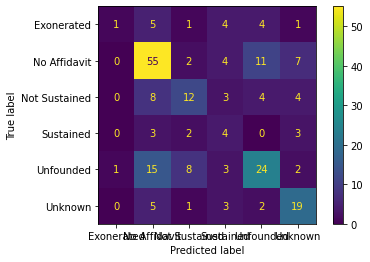

In [132]:
# # Random forest classifier
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


print(classification_report(y_test, y_pred, digits = 3))

cm = confusion_matrix(y_test,y_pred) 
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()